In [9]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.mixture import GaussianMixture

In [36]:
def sliding_volatility(returns, window=20, min_periods=None, annualize=252):
    """
    Calculate sliding volatility for multiple return series.
    
    Parameters:
    -----------
    returns : numpy.ndarray
        Array of shape (T, h) containing h return series of length T
    window : int
        Size of the rolling window
    min_periods : int, optional
        Minimum number of observations required to calculate volatility
        Defaults to window size if None
    annualize : int or None
        Number to use for annualization (e.g., 252 for daily, 52 for weekly)
        If None, returns non-annualized volatility
        
    Returns:
    --------
    numpy.ndarray
        Array of shape (T, h) containing sliding volatilities
        First (window-1) rows will contain NaN unless min_periods is specified
    """
    if min_periods is None:
        min_periods = window
        
    T, h = returns.shape
    vol = np.full((T, h), np.nan)
    
    # Calculate squared returns
    squared_returns = returns ** 2
    
    # Use cumsum for efficient rolling calculation
    cum_squared_returns = np.cumsum(squared_returns, axis=0)
    
    # Calculate rolling sum of squared returns
    for t in range(window-1, T):
        if t >= window:
            # For full windows
            window_sum = (cum_squared_returns[t] - 
                         cum_squared_returns[t-window])
        else:
            # For partial windows at the start
            window_sum = cum_squared_returns[t]
            
        # Count non-NaN observations in current window
        if t >= window:
            n_obs = window - np.isnan(returns[t-window+1:t+1]).sum(axis=0)
        else:
            n_obs = t + 1 - np.isnan(returns[:t+1]).sum(axis=0)
            
        # Calculate volatility where we have enough observations
        mask = n_obs >= min_periods
        if annualize:
            vol[t, mask] = np.sqrt(window_sum[mask] / n_obs[mask] * annualize)
        else:
            vol[t, mask] = np.sqrt(window_sum[mask] / n_obs[mask])
            
    return vol

## Gaussian Mixture and EM

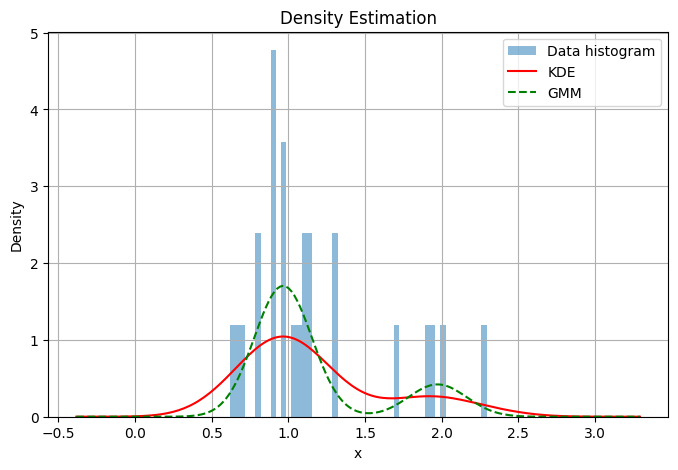

GMM means: [0.9657644  1.97289414]
GMM standard deviations: [0.18732162 0.18977859]
GMM weights: [0.79989272 0.20010728]


In [45]:
# Generate sample data (example: mixture of two Gaussians)
np.random.seed(42)
n1=20
n2=5
data = np.concatenate([
    np.random.normal(1, 0.2, n1),
    np.random.normal(2, 0.2, n2)
])

# Create a grid of points for plotting
x_grid = np.linspace(min(data)-1, max(data)+1, 200)

# 1. Kernel Density Estimation
kde = stats.gaussian_kde(data)
kde_density = kde(x_grid)

# 2. Gaussian Mixture Model
gmm = GaussianMixture(n_components=2)#, random_state=42)
gmm.fit(data.reshape((n1+n2, 1)))
gmm_density = np.exp(gmm.score_samples(x_grid.reshape(-1, 1)))

# Plot everything
plt.figure(figsize=(8, 5))
plt.hist(data, bins=50, density=True, alpha=0.5, label='Data histogram')
plt.plot(x_grid, kde_density, 'r-', label='KDE')
plt.plot(x_grid, gmm_density, 'g--', label='GMM')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Density Estimation')
plt.legend()
plt.grid(True)
plt.show()

# Print GMM parameters
print("GMM means:", gmm.means_.flatten())
print("GMM standard deviations:", np.sqrt(gmm.covariances_.flatten()))
print("GMM weights:", gmm.weights_)

## Generate Spikes

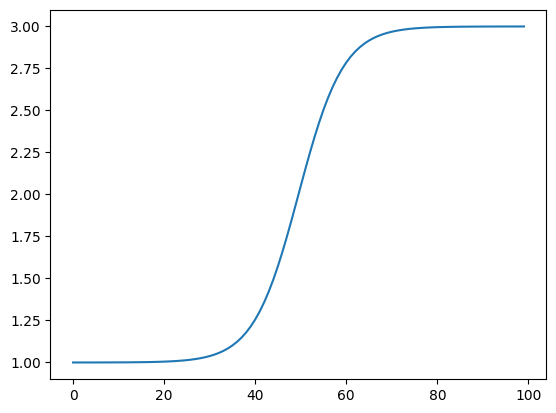

In [28]:
T = 100
s1 = np.ones(T,dtype="float")
s2 = 2+np.tanh(np.linspace(-5,5,T))
plt.plot(s2)

In [64]:
n1=20
n2=5
r = np.zeros((T,n1+n2))
for t in range(T):
    r[t,:n1] = np.random.normal(size=n1, scale=s1[t])
    r[t,n1:] = np.random.normal(size=n2, scale=s2[t])
sigma = sliding_volatility(r)

In [95]:
t = 20

s_hat = np.zeros((T,2))
s_hat[:] = np.nan

for t in range(21,T):
    gmm = GaussianMixture(n_components=2)#, random_state=42)
    gmm.fit(sigma[t,:].reshape(-1,1))
    s_hat[t] = np.sort(gmm.means_.reshape((1,2)))

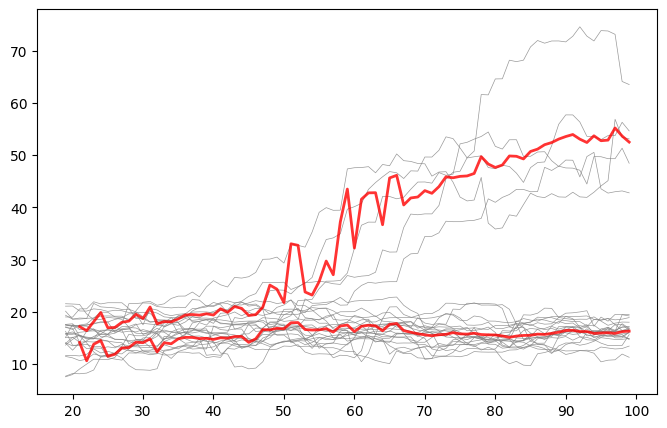

In [96]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(sigma, alpha=0.8, lw=0.5, color="grey")
ax.plot(s_hat, alpha=0.8, lw = 2, color="red")